#### Create score distribution exhibits for CIS189.



In [1]:

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configuration ----------------------------------------------------------------

# csv_path = "G:/My Drive/DMACC/CIS189-202403/CIS189-202403-Grades.csv"
csv_path = "C:/Users/jtriv/Downloads/2024-07-13T0912_Grades-CIS189_30864.csv"
module = 11

# ------------------------------------------------------------------------------

dfall = pd.read_csv(csv_path)

dfpossible = (
    dfall.iloc[0,:]
    .filter(regex="^M")
    .to_frame()
    .reset_index(drop=False)
    .rename({"index": "desc", 0: "possible"}, axis=1)
    )

dfpossible["desc"] = dfpossible["desc"].str.replace(r"\(\d*\)", "", regex=True)
dfpossible["desc"] = dfpossible["desc"].str.strip()
dfpossible[["assignment", "desc"]] = dfpossible["desc"].str.split(":", expand=True)
dfpossible["desc"]  = dfpossible["desc"].str.strip()
dfpossible["assignment"] = dfpossible["assignment"].str.strip()
dfpossible[["module", "assignment"]] = dfpossible["assignment"].str.split(" ", expand=True).iloc[:,:-1]
dfpossible["module"] = dfpossible["module"].str.strip()
dfpossible = dfpossible[dfpossible.module!="Multiple"].reset_index(drop=True)
dfpossible["module"] = dfpossible["module"].str.replace("M", "").astype(int)
dfpossible["assignment"] = dfpossible["assignment"].str.strip()
dfpossible = dfpossible.sort_values(["module", "assignment"])
dfpossible = dfpossible.assign(n=dfpossible.groupby(["module"]).cumcount().astype(int))
dfpossible = dfpossible.drop("assignment", axis=1).rename({"n": "assignment"}, axis=1)
dfpossible["assignment"] = dfpossible["assignment"] + 1
dfassign = dfpossible[["module", "assignment", "desc", "possible"]]
dfassign = dfassign[dfassign.module==module].reset_index(drop=True)

module_columns = [ii for ii in dfall.columns if ii.startswith(f"M{module}")]
keep_columns = ["Student"] + module_columns
df = dfall.iloc[1:,:][keep_columns]
df = (
    df
    .melt(id_vars=['Student'], value_vars=module_columns)
    .rename({"variable": "desc", "value": "grade"}, axis=1)
    )
df["desc"] = df["desc"].str.replace(r"\(\d*\)", "", regex=True)
df[["module", "desc"]] = df["desc"].str.split(":", expand=True)
df["desc"]  = df["desc"].str.strip()
df["module"] = df["module"].str.split(" ", expand=True).iloc[:,:-1]
df["module"]  = df["module"].str.strip()
df["module"] = df["module"].str.replace("M", "").astype(int)
df = df[["module", "desc", "grade"]]
df = df[df.module==module].reset_index(drop=True)
df["grade"] = df["grade"].fillna(0)
df = df.merge(dfassign, on=["desc", "module"], how="left")
df = df[["module", "assignment", "desc", "grade", "possible"]]
print(df.shape)
df.head(10)


(24, 5)


,module,assignment,desc,grade,possible
0,11,1,Class Composition Assignment,10.0,10.0
1,11,1,Class Composition Assignment,10.0,10.0
2,11,1,Class Composition Assignment,10.0,10.0
3,11,1,Class Composition Assignment,10.0,10.0
4,11,1,Class Composition Assignment,0.0,10.0
5,11,1,Class Composition Assignment,10.0,10.0
6,11,1,Class Composition Assignment,10.0,10.0
7,11,1,Class Composition Assignment,10.0,10.0
8,11,1,Class Composition Assignment,10.0,10.0
9,11,1,Class Composition Assignment,7.0,10.0


Text(0.5, 0.98, 'CIS189 Module 11 Assignments')

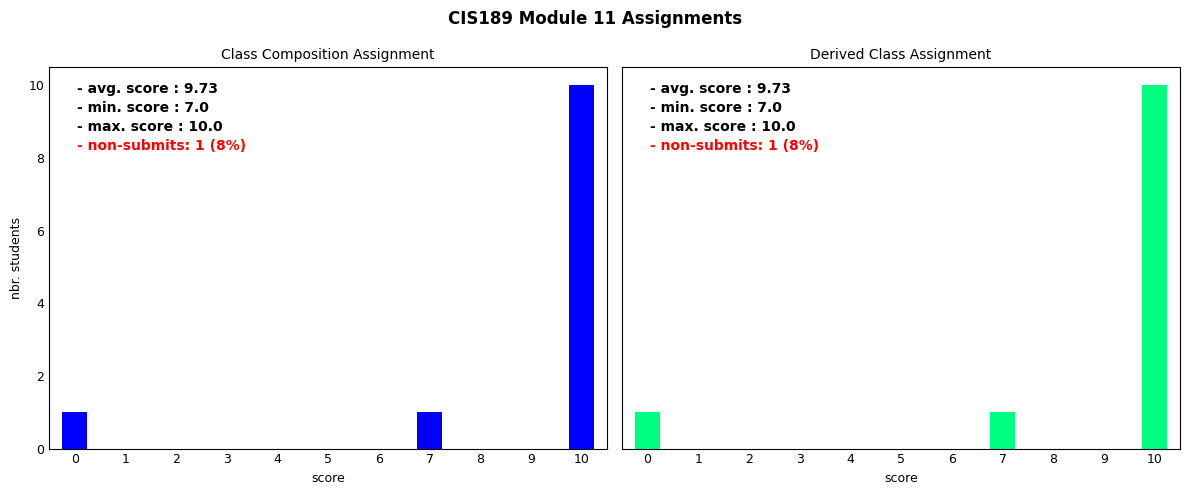

In [2]:

cmap = "winter" #"gist_rainbow" #"winter"

n_facets = dfassign.shape[0]
fcolors = mpl.colormaps.get_cmap(cmap)
colors_rgba = [fcolors(ii) for ii in np.linspace(0, 1, n_facets)]
colors_hex = [mpl.colors.to_hex(ii, keep_alpha=False) for ii in colors_rgba]

# Adjust font sizes based on number of facets.
facet_title_fontsize = 10 if n_facets <=3 else 9
annot_fontsize = 10 if n_facets <= 3 else 9
label_fontsize = 9 if n_facets <= 3 else 8


fig, ax = plt.subplots(1, n_facets, figsize=(12, 5.0), sharey=True, sharex=False, tight_layout=True) 

for ii, color in enumerate(colors_hex):
    module = dfassign.at[ii, "module"]
    assign = dfassign.at[ii, "assignment"]
    desc = dfassign.at[ii, "desc"]
    possible = dfassign.at[ii, "possible"]
    nbr_students = df[(df.module==module) & (df.assignment==assign)].shape[0]
    dfgrades = pd.DataFrame(np.arange(0, possible + 1, dtype=int), columns=["grade"])
    gg = df[df.assignment==assign].groupby("grade", as_index=False).size()
    gg = dfgrades.merge(gg, on="grade", how="left").fillna(0).rename({"size": "n"}, axis=1)
    zs = int(gg[gg.grade==0]["n"].item())
    dfavg = gg[gg.grade!=0]
    avg_score = (dfavg.grade * dfavg.n).sum() / dfavg.n.sum()
    min_score = df[(df.assignment==assign) & (df.grade>0)]["grade"].min().item()
    max_score = df[df.assignment==assign].dropna(how="any")["grade"].max()
    gg = gg.assign(grade=gg["grade"].astype(str), n=gg["n"].astype(int))
    gg.plot.bar(ax=ax[ii], color=color)
    
    ax[ii].set_title(f"{desc}", fontsize=facet_title_fontsize, weight="normal")
    ax[ii].set_xticklabels(gg["grade"].values, rotation=0)
    ax[ii].set_xlabel("score", fontsize=9)
    ax[ii].set_ylabel("nbr. students", fontsize=9)
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=label_fontsize)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=label_fontsize)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")

    missing = int(gg[gg.grade=="0"]["n"].item())
    prop_missing = missing / nbr_students
    avg_desc = f"- avg. score : {avg_score:.2f}"
    min_desc = f"- min. score : {min_score:.1f}"
    max_desc = f"- max. score : {max_score:.1f}"
    na_desc  = f"- non-submits: {missing} ({prop_missing:.0%})"

    ax[ii].annotate(
        avg_desc, xy=(.05, .925), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=annot_fontsize, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        min_desc, xy=(.05, .875), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=annot_fontsize, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        max_desc, xy=(.05, .825), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=annot_fontsize, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        na_desc, xy=(.05, .775), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=annot_fontsize, rotation=0, weight="bold", color="#FF0000"
        ) 
    ax[ii].get_legend().remove()

plt.suptitle(f"CIS189 Module {module} Assignments", weight="bold", size=12)



In [17]:
str(5).zfill(2)

'05'

    # t:/Repos/DMACC-2/CIS189-202403-Supplemental

    C:/Users/jtriv/AppData/Local/Programs/Python/Python312/python.exe exhibit_maker.py --csv-path=C:/Users/jtriv/Downloads/2024-06-16T1128_Grades-CIS189_30864.csv --output-dir=C:/Users/jtriv/Downloads --module=5 --cmap=winter


    
    
    
    parser.add_argument(
        "--csv-path", type=str,
        help="Path to csv file donwloaded from Canvas",
        default=None
        )
    parser.add_argument(
        "--output-dir", type=str,
        help="Directory location to write grade distribution exhibit .png file",
        default=""
        )
    parser.add_argument(
        "--module", type=int,
        help="Module for which to create grade distribution",
        default=3
        )
    parser.add_argument(
        "--cmap", type=str,
        help="Colormap to use for grade distribution exhibits",
        default="winter"
        )